In [ ]:
import pandas as pd
import requests

url = "https://www.anbima.com.br/informacoes/est-termo/CZ.asp"

try:
    response = requests.get(url)
    response.raise_for_status() # Levanta um erro para status 4xx/5xx

    # pandas.read_html tenta encontrar todas as tabelas HTML na string ou URL
    # decimal=',' e thousands='.' são importantes para o formato numérico brasileiro
    tabelas = pd.read_html(response.text, decimal=',', thousands='.')

    if tabelas:
        print(f"Encontradas {len(tabelas)} tabelas HTML na página.")
        # Geralmente, a tabela que você quer é a primeira, ou você pode precisar inspecionar
        # os resultados para encontrar a tabela correta.
        df_base_de_dados = tabelas[0] # Pega a primeira tabela encontrada
        print("\nBase de dados (DataFrame) encontrada:")
        print(df_base_de_dados.head())
    else:
        print("Nenhuma tabela HTML encontrada com pandas.read_html.")

except requests.exceptions.RequestException as e:
    print(f"Erro na requisição HTTP: {e}")
except ValueError:
    print("Erro ao parsear HTML: Nenhuma tabela encontrada ou formato inválido.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")


Erro ao parsear HTML: Nenhuma tabela encontrada ou formato inválido.


/tmp/ipykernel_3399/1583379703.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tabelas = pd.read_html(response.text, decimal=',', thousands='.')


In [14]:
 import ipeadatapy as ipea
 
 df_ettj = ipea.timeseries('ANBIMA12_TJTLN112')

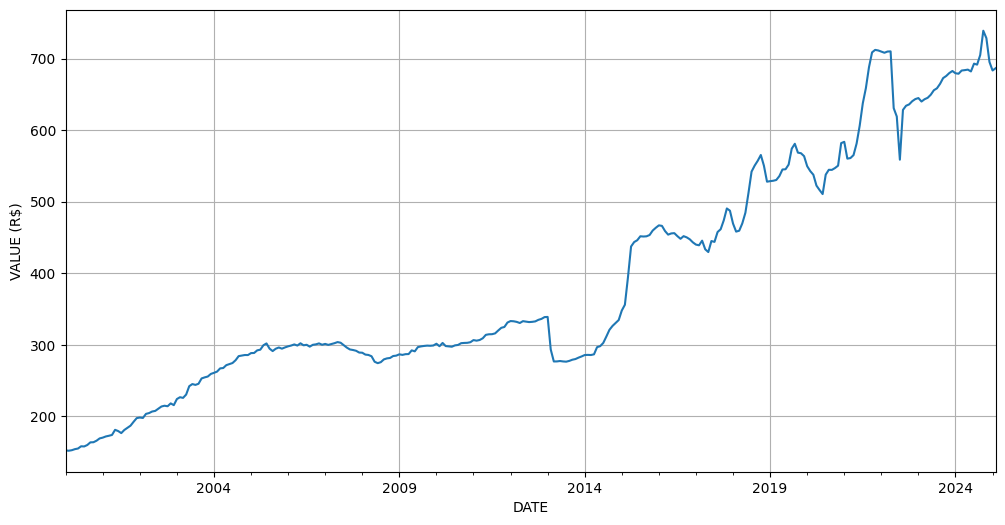

                          CODE                   RAW DATE  DAY  MONTH  YEAR  \
DATE                                                                          
2000-01-01  ELETRO12_CEETRES12  2000-01-01T00:00:00-02:00    1      1  2000   
2000-02-01  ELETRO12_CEETRES12  2000-02-01T00:00:00-02:00    1      2  2000   
2000-03-01  ELETRO12_CEETRES12  2000-03-01T00:00:00-03:00    1      3  2000   
2000-04-01  ELETRO12_CEETRES12  2000-04-01T00:00:00-03:00    1      4  2000   
2000-05-01  ELETRO12_CEETRES12  2000-05-01T00:00:00-03:00    1      5  2000   

            VALUE (R$)  
DATE                    
2000-01-01  152.412150  
2000-02-01  152.031574  
2000-03-01  152.766800  
2000-04-01  154.231380  
2000-05-01  155.108657  


In [51]:
import matplotlib.pyplot as plt

df_energia = ipea.timeseries('ELETRO12_CEETRES12')
df_energia = df_energia['2000-01-01 00:00:00':]

plt.figure(figsize=(12, 6))
df_energia['VALUE (R$)'].plot()
plt.xlabel('DATE')
plt.ylabel('VALUE (R$)')
plt.grid(True)
plt.show()

print(df_energia.head())


In [15]:
ipea.list_series()


,CODE,NAME
0,ABATE_ABPEAV,Abate - aves - peso das carcaças
1,ABATE_ABQUBV,Abate - bovinos - quantidade
2,ABATE12_ABPEVA12,Abate - vacas - peso das carcaças
3,ABATE12_ABQUBO12,Abate - bois - quantidade
4,ABATE12_ABQUBV12,Abate - bovinos - quantidade
...,...,...
2793,PNADCT_TXPARTCUF_SI,Taxa de participação - sem instrução ou equiva...
2794,PNAD_IAGRV,Domicílios com insegurança alimentar grave
2795,PNAD_IALEV,Domicílios com insegurança alimentar leve
2796,PNAD_IAMOD,Domicílios com insegurança alimentar moderada


In [92]:
titulos = pd.read_excel('dados/titulos-publicos-precos-06-06-2025-17-27-58.xls')

titulos['Prazo'] = pd.to_datetime(titulos['Data de vencimento'], format= '%d/%m/%Y') - pd.to_datetime(titulos['Data de referência'], format= '%d/%m/%Y')
titulos['Prazo'] = titulos['Prazo'].dt.days



/home/hspassos/anaconda3/envs/bcb/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [94]:
import numpy as np

titulos = titulos[titulos['Tipo do título'] == 'LTN']

def svensson_model(m, params):
    """
    Calcula a taxa de juros de acordo com o modelo de Svensson.

    Args:
        m (float or np.array): Vencimento (maturidade) em anos.
        params (list or np.array): Lista ou array dos 6 parâmetros [beta0, beta1, beta2, beta3, tau1, tau2].

    Returns:
        float or np.array: Taxa de juros prevista pelo modelo para o vencimento m.
    """
    beta0, beta1, beta2, beta3, tau1, tau2 = params

    # Evitar divisão por zero para m muito pequeno
    m_safe = np.where(m == 0, 1e-9, m)

    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-m_safe / tau1)) / (m_safe / tau1))
    term3 = beta2 * ((1 - np.exp(-m_safe / tau1)) / (m_safe / tau1) - np.exp(-m_safe / tau1))
    term4 = beta3 * ((1 - np.exp(-m_safe / tau2)) / (m_safe / tau2) - np.exp(-m_safe / tau2))

    return term1 + term2 + term3 + term4

def objective_function(params, maturities_obs, yields_obs):
    """
    Função objetivo para minimizar a soma dos quadrados dos erros.

    Args:
        params (list or np.array): Parâmetros do modelo de Svensson a serem otimizados.
        maturities_obs (np.array): Vencimentos observados no mercado.
        yields_obs (np.array): Taxas de juros observadas no mercado correspondentes aos vencimentos.

    Returns:
        float: Soma dos quadrados dos erros.
    """
    predicted_yields = svensson_model(maturities_obs, params)
    errors = yields_obs - predicted_yields
    return np.sum(errors**2)

maturities_obs = np.array(titulos['Prazo'])
yields_obs = np.array(titulos['Taxa indicativa'])

Estimação bem-sucedida. Parâmetros do Svensson: [ 13.48069663   5.23541863   5.18229772   4.03746252   2.16393146
 103.16860123]
Soma dos quadrados dos erros (RSS): 1.5828985269744063


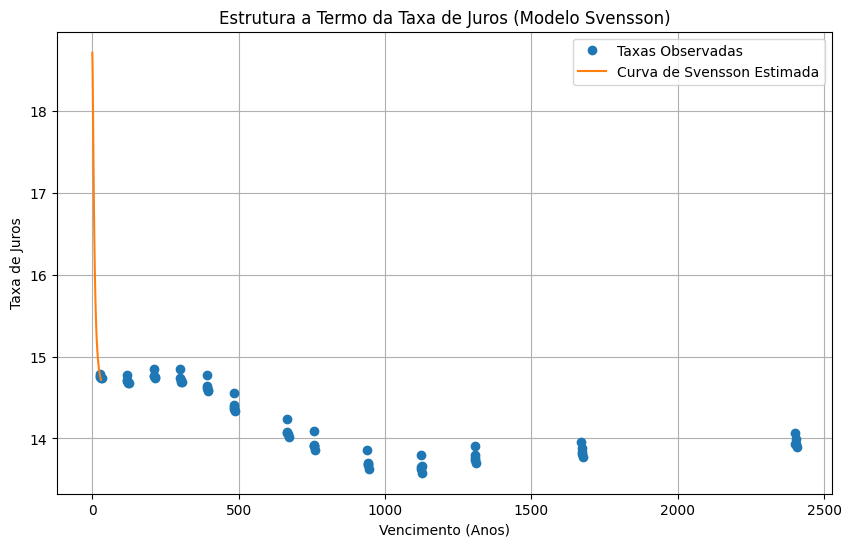

In [95]:
from scipy.optimize import minimize

initial_params = [0.05, -0.01, 0.01, -0.005, 1.0, 5.0]

# Restrições (opcional, mas recomendado para tau1 e tau2 serem positivos)
bounds = ((None, None), (None, None), (None, None), (None, None), (1e-6, None), (1e-6, None))

# Realizar a otimização
result = minimize(objective_function, initial_params, args=(maturities_obs, yields_obs),
                  method='L-BFGS-B', bounds=bounds)

# Exibir os resultados
if result.success:
    estimated_params = result.x
    print(f"Estimação bem-sucedida. Parâmetros do Svensson: {estimated_params}")
    print(f"Soma dos quadrados dos erros (RSS): {result.fun}")

    # Gerar a curva estimada
    maturities_plot = np.linspace(0.1, 30, 100) # Para uma curva suave
    estimated_yields = svensson_model(maturities_plot, estimated_params)

    # Plotar a curva
    plt.figure(figsize=(10, 6))
    plt.plot(maturities_obs, yields_obs, 'o', label='Taxas Observadas')
    plt.plot(maturities_plot, estimated_yields, label='Curva de Svensson Estimada')
    plt.title('Estrutura a Termo da Taxa de Juros (Modelo Svensson)')
    plt.xlabel('Vencimento (Anos)')
    plt.ylabel('Taxa de Juros')
    plt.grid(True)
    plt.legend()
    plt.show()

else:
    print("A otimização não convergiu.")
    print(result)

Estimando ETTJ 19/09/2025

In [2]:
import pandas as pd

estimadores_1909 = pd.read_csv('dados/ettj_19092025.csv', sep=';', decimal=',', thousands='.', encoding='latin1', nrows=2)
indice = estimadores_1909.columns[0]
estimadores_1909.set_index(indice, inplace=True)
estimadores_1909 = estimadores_1909.transpose()

ettj_1909 = pd.read_csv('dados/ettj_19092025.csv', sep=';', decimal=',', thousands='.', encoding='latin1', skiprows=5, nrows=67)

prefixados_circular_3361_1909 = pd.read_csv('dados/ettj_19092025.csv', sep=';', decimal=',', thousands='.', encoding='latin1', skiprows=75, nrows=10)

erro_titulo_a_titulo_1909 = pd.read_csv('dados/ettj_19092025.csv', sep=';', decimal=',', thousands='.', encoding='latin1', skiprows=88)

#ettj_1909['Vertices'] = pd.to_numeric(ettj_1909['Vertices'])

#ettj_1909 = ettj_1909.astype({'Vertices': 'float64', 'ETTJ IPCA': 'float64', 'ETTJ PREF': 'float64', 'Inflação Implícita': 'float64'})
#bp_bancos['cnpj'] = bp_bancos['cnpj'].astype(str)

estimadores_1809 = pd.read_csv('dados/ettj_18092025.csv', sep=';', decimal=',', thousands='.', encoding='latin1', nrows=2)
indice = estimadores_1809.columns[0]
estimadores_1809.set_index(indice, inplace=True)
estimadores_1809 = estimadores_1809.transpose()

ettj_1809 = pd.read_csv('dados/ettj_18092025.csv', sep=';', decimal=',', thousands='.', encoding='latin1', skiprows=5, nrows=67)

prefixados_circular_3361_1809 = pd.read_csv('dados/ettj_18092025.csv', sep=';', decimal=',', thousands='.', encoding='latin1', skiprows=75, nrows=10)

erro_titulo_a_titulo_1809 = pd.read_csv('dados/ettj_18092025.csv', sep=';', decimal=',', thousands='.', encoding='latin1', skiprows=88)


--- Resultado da Regressão NSS ---
Status da Otimização: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
Erro Quadrático Mínimo (EQM): 0.00000000

Coeficientes Estimados (Betas):
Beta 0 (Nível):   0.0699
Beta 1 (Inclinação): 0.0755
Beta 2 (Curvatura 1):0.0832
Beta 3 (Curvatura 2):0.1950


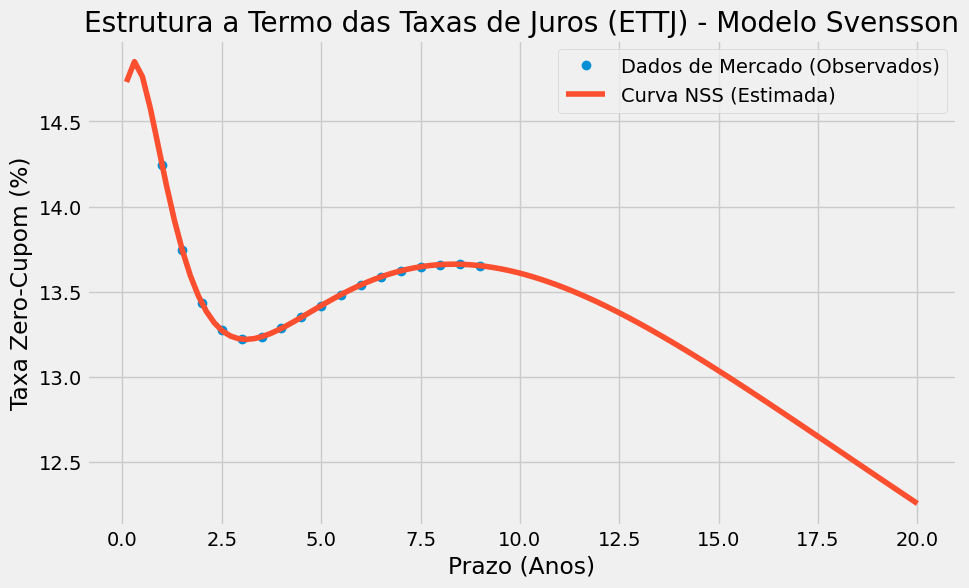

In [12]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

lambda1 = 1.9860
lambda2 = 0.1719

prazos = ettj_1909['Vertices']/252
taxas_observadas = ettj_1909['ETTJ PREF']/100

def nss_model(betas, tau, lambda1, lambda2):
    """
    Calcula a taxa zero-cupom R(tau) usando o modelo Nelson-Siegel-Svensson.
    betas: vetor [beta0, beta1, beta2, beta3]
    tau: vetor de prazos
    lambda1 e lambda2: constantes fixadas
    """
    beta0, beta1, beta2, beta3 = betas
    
    # Previne a divisão por zero para tau=0, embora em dados reais tau > 0
    tau[tau == 0] = 1e-6 
    
    termo_nivel = beta0
    
    termo_inclinacao = beta1 * (1.0 - np.exp(-lambda1 * tau)) / (lambda1 * tau)
    
    termo_curvatura1 = beta2 * ( (1.0 - np.exp(-lambda1 * tau)) / (lambda1 * tau) - np.exp(-lambda1 * tau) )
    
    termo_curvatura2 = beta3 * ( (1.0 - np.exp(-lambda2 * tau)) / (lambda2 * tau) - np.exp(-lambda2 * tau) )

    return termo_nivel + termo_inclinacao + termo_curvatura1 + termo_curvatura2

def erro_quadratico(betas, tau, taxas_observadas, lambda1, lambda2):
    """
    Calcula o Erro Quadrático Médio (EQM) entre as taxas do modelo e as taxas observadas. Este é o valor que o 'minimize' tentará reduzir.
    """
    taxas_estimadas = nss_model(betas, tau, lambda1, lambda2)
    # Retorna a soma dos erros quadrados (Root Mean Square Error)
    return np.sum((taxas_observadas - taxas_estimadas)**2)

# Chute inicial para os betas: [beta0, beta1, beta2, beta3]
chute_inicial = [0.10, 0.0, 0.0, 0.0]

# Executa a otimização
resultado = minimize(
    erro_quadratico,              # Função de erro a ser minimizada
    chute_inicial,
    args=(prazos, taxas_observadas, lambda1, lambda2),
    method='L-BFGS-B'             # Algoritmo de otimização (um bom padrão para este problema)
)

betas_estimados = resultado.x

print("--- Resultado da Regressão NSS ---")
print(f"Status da Otimização: {resultado.message}")
print(f"Erro Quadrático Mínimo (EQM): {resultado.fun:.8f}")
print("\nCoeficientes Estimados (Betas):")
print(f"Beta 0 (Nível):   {betas_estimados[0]:.4f}")
print(f"Beta 1 (Inclinação): {betas_estimados[1]:.4f}")
print(f"Beta 2 (Curvatura 1):{betas_estimados[2]:.4f}")
print(f"Beta 3 (Curvatura 2):{betas_estimados[3]:.4f}")

# Gera a curva modelada usando os Betas estimados
tau_curva = np.linspace(0.1, 20, 100)
taxas_modeladas = nss_model(betas_estimados, tau_curva, lambda1, lambda2)

plt.figure(figsize=(10, 6))
plt.plot(prazos, taxas_observadas * 100, 'o', label='Dados de Mercado (Observados)')
plt.plot(tau_curva, taxas_modeladas * 100, '-', label='Curva NSS (Estimada)')
plt.title('Estrutura a Termo das Taxas de Juros (ETTJ) - Modelo Svensson')
plt.xlabel('Prazo (Anos)')
plt.ylabel('Taxa Zero-Cupom (%)')
plt.legend()
plt.grid(True)
plt.show()


In [48]:
import pyettj.modelo_ettj as modelo_ettj

curva = estimadores_1909['PREFIXADOS']

beta1, beta2, beta3, beta4 = curva[:4]
lambda1, lambda2 = curva[4:]
t = 21/252 #em anos

taxa = modelo_ettj.svensson(beta1, beta2, beta3, beta4, lambda1, lambda2, t)
print(taxa)

0.14710757734694202


In [1]:
import pyettj.ettj as ettj
data = '18/05/2021'
ettj_dataframe = ettj.get_ettj(data)

pyettj 0.3.3
Curvas capturadas em 1.65 segundos.


pyettj 0.3.3
Curvas capturadas em 2.01 segundos.


<Figure size 640x480 with 0 Axes>

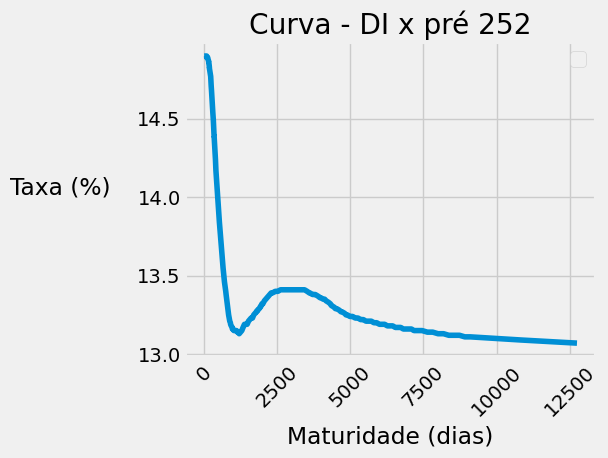

<Figure size 640x480 with 0 Axes>

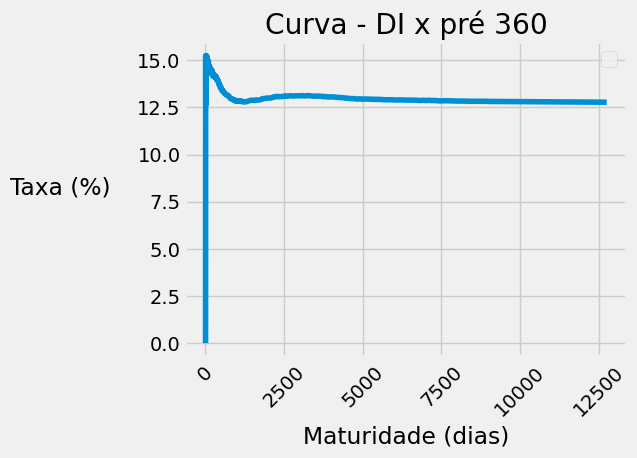

In [2]:
# Curva de juros construída a partir dos preços de ajustes dos vencimentos do Contrato Futuro de Taxa Média de Depósitos Interfinanceiros de Um Dia (DI1) negociado na B3
import pyettj.ettj as ettj
data = '19/09/2025'
ettj_dataframe = ettj.get_ettj(data)

curva = "DI x pré 252"
ettj.plot_ettj(ettj_dataframe, curva, data)
curva = "DI x pré 360"
ettj.plot_ettj(ettj_dataframe, curva, data)

In [16]:
de = '01/01/2010'
ate ='31/12/2010'
datas = ettj.listar_dias_uteis(de, ate)

todas_datas = pd.DataFrame()
for dat in datas:
    ano, mes, dia = dat.split("-")
    data = "/".join([dia, mes, ano])
    dados = ettj.get_ettj(data)
    todas_datas=pd.concat([dados, todas_datas])

Curvas capturadas em 2.14 segundos.
Curvas capturadas em 2.11 segundos.
Curvas capturadas em 2.38 segundos.
Curvas capturadas em 2.47 segundos.
Curvas capturadas em 2.64 segundos.
Curvas capturadas em 6.14 segundos.
Curvas capturadas em 2.41 segundos.
Curvas capturadas em 2.78 segundos.
Curvas capturadas em 2.6 segundos.
Curvas capturadas em 2.44 segundos.
Curvas capturadas em 2.55 segundos.
Curvas capturadas em 2.58 segundos.
Curvas capturadas em 2.39 segundos.
Curvas capturadas em 2.64 segundos.
Curvas capturadas em 2.64 segundos.


ValueError: Não há dados para a data fornecida. Dados a partir de 02/01/2004.